In [1]:
# Functions for setting up and playing TicTacToe
import numpy as numpy
import pickle
import copy

# Generate an empty board
def getEmptyBoard():
    return [0,0,0,0,0,0,0,0,0]


# Generate a random board, never return a board that can't exist when following the game rules
def getRandomBoard():
    board = list(numpy.random.choice([0,1,2],(9)))
    if board.count(1) - board.count(2) < 0 or board.count(1) - board.count(2) > 1:
        return getRandomBoard()
    return board


# Show the board
def showBoard(board):
    S=""
    T=["·","O","X"]
    for i in [0,3,6]:
        S=S+T[board[i]]+" "+T[board[i+1]]+" "+T[board[i+2]]
        S=S+"\n"
    print (S)


# Check for winning line
def score(board):
    line=0
    if board[0]==board[1] and board[1]==board[2] and board[0]!=0:
        line=board[0]
    if board[3]==board[4] and board[4]==board[5] and board[3]!=0:
        line=board[3]
    if board[6]==board[7] and board[7]==board[8] and board[6]!=0:
        line=board[6]
        
    if board[0]==board[3] and board[3]==board[6] and board[0]!=0:
        line=board[0]
    if board[1]==board[4] and board[4]==board[7] and board[1]!=0:
        line=board[1]
    if board[2]==board[5] and board[5]==board[8] and board[2]!=0:
        line=board[2]

    if board[0]==board[4] and board[4]==board[8] and board[0]!=0:
        line=board[0]
    if board[2]==board[4] and board[4]==board[6] and board[2]!=0:
        line=board[2]  
    return line


# Check if the game is over
def gameOver(board):
    s=score(board)
    if board.count(0)==0 or s!=0:
        return True
    return False


# Make a move
def doMove(board,move,who):
    newBoard=copy.deepcopy(board)
    newBoard[move]=who
    return newBoard


# Get all legal moves
def getAllMoves(board):
    ret=[]
    for i in range(9):
        if board[i]==0:
            ret.append(i)
    return ret

In [2]:
# Test empty board
print("Empty board tests:")
testEmptyBoard = getEmptyBoard()
print(testEmptyBoard)
showBoard(testEmptyBoard)
print("Score:",score(testEmptyBoard))

# Test random boards
noOfTests = 3
print("\n%d random board tests:\n" % noOfTests)

for i in range(noOfTests):
    print("Run",i+1)
    testRandomBoard = getRandomBoard()
    showBoard(testRandomBoard)
    print("Score:",score(testRandomBoard),"\n")

# Test doMove
print("\nTest doMove():")
testDoMove=getEmptyBoard()
showBoard(testDoMove)
testDoMove=doMove(testDoMove,4,1)
showBoard(testDoMove)

# Test getAllMoves
print("\nTest getAllMoves():")
testGetAllMoves=getRandomBoard()
showBoard(testGetAllMoves)
print(getAllMoves(testGetAllMoves))

# Test gameOver
print("\nTest gameOver():")
for i in range(4):
    testGameOver=getRandomBoard()
    showBoard(testGameOver)
    print(gameOver(testGameOver),"\n---")

Empty board tests:
[0, 0, 0, 0, 0, 0, 0, 0, 0]
· · ·
· · ·
· · ·

Score: 0

3 random board tests:

Run 1
X O ·
O O X
X O ·

Score: 1 

Run 2
O X O
· · ·
· · ·

Score: 0 

Run 3
O O ·
X X O
X O ·

Score: 0 


Test doMove():
· · ·
· · ·
· · ·

· · ·
· O ·
· · ·


Test getAllMoves():
X X ·
O · ·
O O X

[2, 4, 5]

Test gameOver():
· X O
· O X
· · ·

False 
---
O · X
O O ·
X · ·

False 
---
X X X
O O X
O · O

True 
---
· X ·
O O O
X X O

True 
---


In [3]:
# Generate randomPolicy function
def addPossibleBoards(board,who):
    moves=getAllMoves(board)
    V=numpy.ones(len(moves))
    V=V/V.sum()
    if score(board)==0 and list(board).count(0)!=0:
        randomPolicy[tuple(board)]=V
    flipMove=[0,2,1]
    for move in moves:
        newBoard=doMove(board,move,who)
        addPossibleBoards(newBoard,flipMove[who])

# Load randomPolicy from file, if the file doesn't exist, generate the policy
try:
    randomPolicy=pickle.load(open("./inClassRandomPolicy.p","rb"))
    print("Loaded randomPolicy from './inClassRandomPolicy.p'")
except:
    # Generate randomPolicy and save it to file
    randomPolicy=dict()  
    board=getEmptyBoard()
    addPossibleBoards(board,1)
    pickle.dump(randomPolicy,open("./inClassRandomPolicy.p","wb"))
    print("Generated randomPolicy and saved it to './inClassRandomPolicy.p'")

Loaded randomPolicy from './inClassRandomPolicy.p'


In [4]:
# Load perfectPolicy from file
try:
    perfectPolicy=pickle.load(open("./perfectPolicy.p","rb"))
    print("Loaded perfectPolicy from './perfectPolicy.p'")
except:
    print("Could not load perfectPolicy from './perfectPolicy.p'")


Loaded perfectPolicy from './perfectPolicy.p'


In [5]:
# Load Q-table from file, if the file doesn't exist, create an empty dictionary
try:
    Q=pickle.load(open("./QlearningStrategy.p","rb"))
    ql_policy = {}
    print("Loaded QlearningStrategy from './QlearningStrategy.p'")
except:
    Q=dict()
    ql_policy = {}
    print("Created empty QlearningStrategy and ql_policy dictionaries.")

Created empty QlearningStrategy and ql_policy dictionaries.


In [6]:
# Initialize the Q-table with some initial values
# The keys are tuples representing the states and the values are arrays of size 9 representing the Q-values for each possible move
# in that state

# Define the learning rate and the discount factor
alpha = 0.1
gamma = 0.9

# Define the exploration policy, such as epsilon-greedy
epsilon = 0.5

# Define the number of episodes to train the policy
num_episodes = 1000000

# flipMove is used to switch between players
flipMove=[0,2,1]

# Define who starts the game
who = 1

# Define a function to get the Q-value for a given state and action
def getQ(state, action):
    if tuple(state) not in Q:
        Q[tuple(state)] = numpy.zeros(9)
    return Q[tuple(state)][action]

# Define a function to update the Q-value for a given state and action
def updateQ(state, action, value):
    if tuple(state) not in Q:
        Q[tuple(state)] = numpy.zeros(9)
    Q[tuple(state)][action] = value

# Train the Q-learning policy
for i in range(num_episodes):
    # Start a new game
    board = getEmptyBoard()

    while not gameOver(board):
        # Select the next action using the exploration policy
        moves = getAllMoves(board)
        if numpy.random.uniform(0, 1) < epsilon:
            # Choose a random move with probability epsilon
            action = numpy.random.choice(moves)
        else:
            # Choose the move with the highest Q-value with probability 1 - epsilon
            action = numpy.argmax([getQ(board, move) for move in moves])

        # Make the selected move
        next_board = doMove(board, action, who)

        # Update the Q-value for the current state and action
        reward = score(next_board)
        if gameOver(next_board):
            updateQ(board, action, reward)
        else:
            next_moves = getAllMoves(next_board)
            updateQ(board, action, (1 - alpha) * getQ(board, action) + alpha * (reward + gamma * max([getQ(next_board, next_move) for next_move in next_moves])))
        
        board = next_board
        who = flipMove[who]


# Function to convert Q-values to a probability distribution (SOFTMAX)
""" def q_to_prob(q_values, legal_moves):
    prob = numpy.zeros(len(q_values))
    prob[legal_moves] = numpy.exp(q_values[legal_moves])
    prob[legal_moves] /= prob[legal_moves].sum()
    return prob """

def q_to_prob(q_values, legal_moves):
    legal_prob = numpy.zeros(len(legal_moves))
    legal_prob = numpy.exp(q_values[legal_moves]) / numpy.sum(numpy.exp(q_values[legal_moves]))
    return legal_prob

""" # Function to convert Q-values to a probability distribution (ARGMAX)
def q_to_prob(q_values,legal_moves):
    prob = numpy.zeros(len(legal_moves))
    best_action = numpy.argmax(q_values[legal_moves])
    prob[best_action] = 1
    return prob """

# Create a new dictionary to store the Q-learning policy as a probability distribution
for state in Q:
    legal_moves = getAllMoves(list(state))
    q_values = Q[state]
    ql_policy[state] = q_to_prob(q_values, legal_moves)

# Save QlearningStrategy and ql_policy to file
pickle.dump(Q,open("./QlearningStrategy.p","wb"))
pickle.dump(ql_policy,open("./ql_policy.p","wb"))

In [7]:
# Functions for testing policies against eachother

# Play a game between two policies
def playTwoPolicies(policyA,policyB,verbose=False):
    flipMove=[0,2,1]
    who=1
    board=[0,0,0,0,0,0,0,0,0]
    done=False
    while not done:
        if verbose:
            showBoard(board)
        moves=getAllMoves(board)
        if who==1:
            p=policyA[tuple(board)]
        else:
            p=policyB[tuple(board)]
        if verbose:
            print(p,"\n---")
        p/=p.sum()
        choice=numpy.random.choice(moves,p=p)
        board=doMove(board,choice,who)
        s=score(board)
        if len(moves)==1 or s!=0:
            done=True
        who=flipMove[who]
    if verbose:
        showBoard(board)
    if s==0:
        return 0
    return flipMove[who]


# Sample games between two policies
winners = []
def sampleGames(policyA, policyB, nrOfGames=100):
    winners.clear()
    result = [0, 0, 0]
    for _ in range(nrOfGames):
        winner = playTwoPolicies(policyA, policyB)
        winners.append(winner)
        if winner == 0:
            result[0] += 1
        elif winner == 1:
            result[1] += 1
        else:
            result[2] += 1
    result = numpy.array(result)
    return result / result.sum()

In [8]:
# Benchmarking

# Play a game between two policies
#playTwoPolicies(randomPolicy,randomPolicy,verbose=False)
#playTwoPolicies(randomPolicy,perfectPolicy,verbose=False)
#playTwoPolicies(randomPolicy,ql_policy,verbose=False)
#playTwoPolicies(perfectPolicy,perfectPolicy,verbose=False)
#playTwoPolicies(perfectPolicy,randomPolicy,verbose=False)
#playTwoPolicies(perfectPolicy,ql_policy,verbose=False)
#playTwoPolicies(ql_policy,ql_policy,verbose=False)
#playTwoPolicies(ql_policy,perfectPolicy,verbose=False)
#playTwoPolicies(ql_policy,randomPolicy,verbose=False)

# Sample games between policies
#print("randomPolicy vs randomPolicy [draw, win, lose]",sampleGames(randomPolicy,randomPolicy,nrOfGames=100000))
#print("randomPolicy vs perfectPolicy [draw, win, lose]",sampleGames(randomPolicy,perfectPolicy,nrOfGames=100000))
#print("randomPolicy vs ql_policy [draw, win, lose]",sampleGames(randomPolicy,ql_policy,nrOfGames=100000))
#print("perfectPolicy vs perfectPolicy [draw, win, lose]",sampleGames(perfectPolicy,perfectPolicy,nrOfGames=100000))
#print("perfectPolicy vs randomPolicy [draw, win, lose]",sampleGames(perfectPolicy,randomPolicy,nrOfGames=100000))
#print("perfectPolicy vs ql_policy [draw, win, lose]",sampleGames(perfectPolicy,ql_policy,nrOfGames=100000))
print("ql_policy vs ql_policy [draw, win, lose]",sampleGames(ql_policy,ql_policy,nrOfGames=100000))
print("ql_policy vs perfectPolicy [draw, win, lose]",sampleGames(ql_policy,perfectPolicy,nrOfGames=100000))
print("ql_policy vs randomPolicy [draw, win, lose]",sampleGames(ql_policy,randomPolicy,nrOfGames=100000))

ql_policy vs ql_policy [draw, win, lose] [0.11936 0.51955 0.36109]
ql_policy vs perfectPolicy [draw, win, lose] [0.27827 0.      0.72173]
ql_policy vs randomPolicy [draw, win, lose] [0.14311 0.57459 0.2823 ]


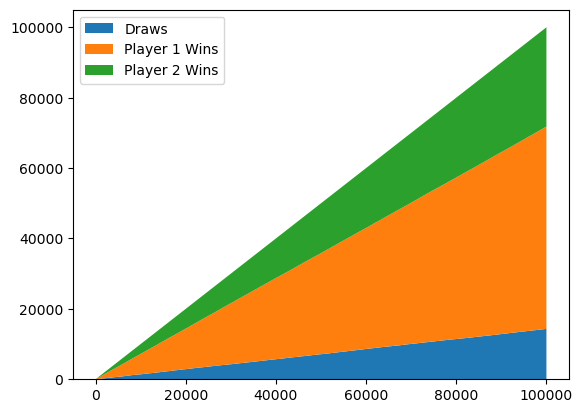

In [9]:
import matplotlib.pyplot as plt

# Create lists to store the cumulative number of games for each outcome
draws = []
p1_wins = []
p2_wins = []

# Iterate through the winners list and update the cumulative counts
cumulative_draws = 0
cumulative_p1_wins = 0
cumulative_p2_wins = 0
for i, winner in enumerate(winners):
    if winner == 0:
        cumulative_draws += 1
    elif winner == 1:
        cumulative_p1_wins += 1
    else:
        cumulative_p2_wins += 1
    draws.append(cumulative_draws)
    p1_wins.append(cumulative_p1_wins)
    p2_wins.append(cumulative_p2_wins)

# Create the stacked area chart
plt.stackplot(range(len(winners)), draws, p1_wins, p2_wins, labels=['Draws', 'Player 1 Wins', 'Player 2 Wins'])
plt.legend(loc='upper left')
plt.show()

In [11]:
# Test different polcies
print("randomPolicy")
print(len(randomPolicy))
print(randomPolicy[tuple(getEmptyBoard())])
board=[1,1,2,2,1,0,0,0,2]
showBoard(board)
print(randomPolicy[tuple(board)])

print("\n-----------------------------\nperfectPolicy")
print(len(perfectPolicy))
print(perfectPolicy[tuple(getEmptyBoard())])
board=[1,1,2,2,1,0,0,0,2]
showBoard(board)
print(perfectPolicy[tuple(board)])

print("\n-----------------------------\nQ-table")
print(len(Q))
print(Q[tuple(getEmptyBoard())])
board=[1,1,2,2,1,0,0,0,2]
showBoard(board)
print(Q[tuple(board)])

print("\n-----------------------------\nql_policy")
print(len(ql_policy))
print(ql_policy[tuple(getEmptyBoard())])
board=[1,1,2,2,1,0,0,0,2]
showBoard(board)
print(ql_policy[tuple(board)])

randomPolicy
4520
[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
O O X
X O ·
· · X

[0.33333333 0.33333333 0.33333333]

-----------------------------
perfectPolicy
4520
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
O O X
X O ·
· · X

[0. 0. 1.]

-----------------------------
Q-table
10900
[1.34779866 1.34027988 1.34721846 1.35441953 1.3442341  1.38293498
 1.34967001 1.34644774 1.32934056]
O O X
X O ·
· · X

[1.78156265 0.8520738  0.         0.         0.         2.
 1.79317625 1.46004807 0.        ]

-----------------------------
ql_policy
10900
[0.11095074 0.11011965 0.11088638 0.11168776 0.11055595 0.11491843
 0.11115856 0.11080095 0.10892158]
O O X
X O ·
· · X

[0.41737286 0.33939215 0.243235  ]
